# Section 1

In this notebook, we prepare plots for Section 1 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
FORCE_FLAG = False

base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"
filepath = base_p / "df_task_experimental_data.tsv"
closed_performance_expdata_fp = base_p.parent / "closed_performance_experimental_data.tsv"

## Load
if not filepath.exists() or FORCE_FLAG:
    experiment_ids = ["11", "14"]
    df = utils.MLFlowTaskAPI.mlflow_results_as_dataframe(
        experiment_ids, run_name="dev-v0.1.3-expdata", classify_tasks=True
    )

    # Drop HELP_high
    df = df.query("ag_pos != 'HELP_high'").copy()

    df.to_csv(filepath, sep="\t", index=False)
else:
    df = pd.read_csv(
        filepath,
        sep="\t",
        index_col=False,
        dtype={"ag_pos": str, "ag_neg": str, "experiment": str},
    )

## Clean task types
df["task_type_clean"] = df["task_type"].replace(visualisations.PlotParams.map_task_type_to_clean)

## Load swa performances and merge into df
df_swa = pd.read_csv(closed_performance_expdata_fp, sep='\t')
df_swa.head()

## Add to df task column with task encoded as string, similar logic as df_swa
tasks_encoded = []
for i, row in df.iterrows():
    task_type = datasets.ClassificationTaskType.from_str(row["task_type"])
    t = datasets.ClassificationTask(
        task_type=task_type,
        ag_pos=row["ag_pos"] if "_" not in row["ag_pos"] else row["ag_pos"].split("_")[0],
        ag_neg=row["ag_neg"] if task_type == datasets.ClassificationTaskType.ONE_VS_ONE else "auto",
        seed_id=row["seed_id"],
        split_id=row["split_seed"],  # not split_id !
    )
    tasks_encoded.append(repr(t))
df["task"] = tasks_encoded


## There are duplicated runs, with same results, for df.query("split_seed == 42 and seed_id == '0'")["task_type"].value_counts()
## Will remove them
mask_dupl = df.duplicated(subset=["task", "ag_pos", "ag_neg", "seed_id", "split_seed", "acc_closed"])
print("Duplicates:", mask_dupl.sum(), "Removed.")
df = df.loc[~mask_dupl].copy()

# ## Merge
assert set(df_swa["task"]) == set(df["task"]), "Tasks in df_swa and df do not match"
df = df.merge(df_swa[["task", "acc"]].rename(columns={"acc": "acc_swa"}), on="task", how="left")

Duplicates: 0 Removed.


Text(0.5, 1.0, 'SWA can add 0.25% accuracy points on average')

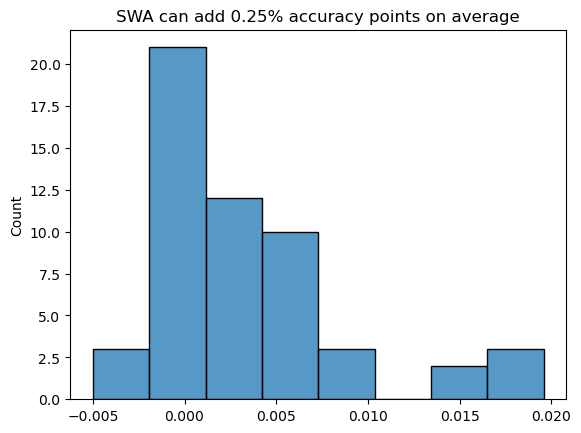

In [3]:
## Check that all tasks are in df_swa
# df_swa["split_id"] = df_swa["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).split_id)
# df_swa["seed_id"] = df_swa["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).seed_id)
# df_swa[["split_id", "seed_id"]].value_counts()

# df["task_type"].value_counts(), df[["split_seed", "seed_id"]].value_counts()

## SWA advantage
sns.histplot(df["acc_swa"] - df["acc_closed"])
plt.title(r"SWA can add 0.25% accuracy points on average")

## 1A. Performances across tasks

### 1A2 - looser, 95low and 1v9 performances.

In [4]:
df_13 = df.loc[df["experiment"].isin(["11", "13", "14"])].copy()
df_13["ag_pos"] = df_13["ag_pos"].apply(lambda x: x.split("_")[0])

# Get order of antigens by high_vs_looser performance
ag_order = df_13.loc[df_13["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [5]:
# task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_order = ["high_vs_95low", "high_vs_looser", "1v1"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

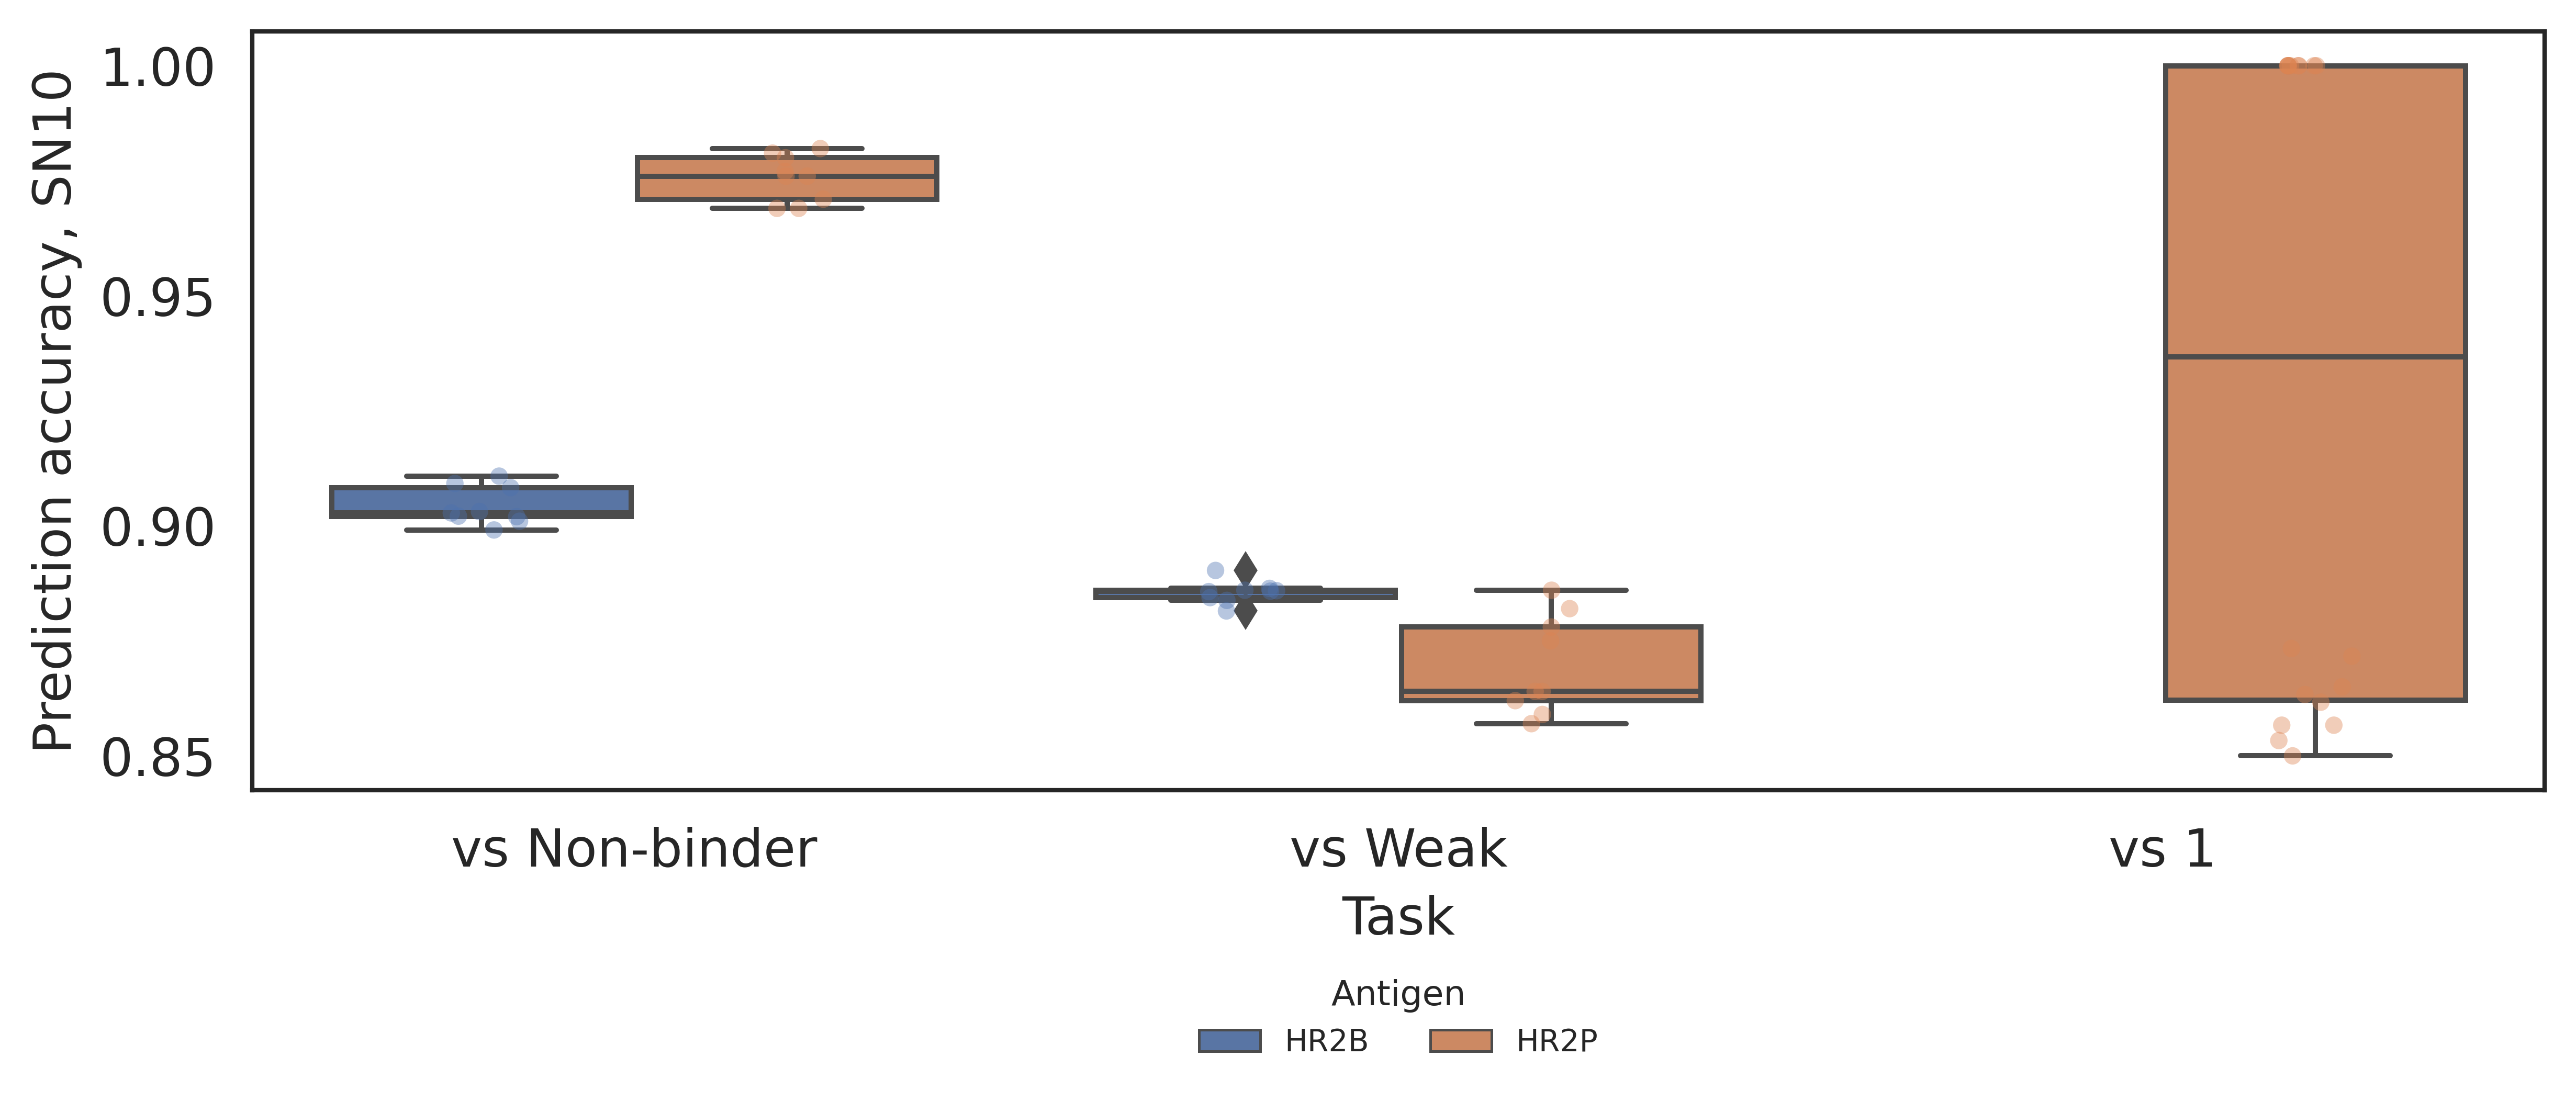

In [6]:
yticks = np.arange(0.85, 1.0, 0.05)
yaxis_title = "Prediction accuracy, SN10"
# ag_order = visualisations.PlotParams.order_antigens
# task_order = visualisations.PlotParams.order_tasks
# task_clean_order = visualisations.PlotParams.order_tasks_clean
# cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df_13,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    # palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df_13,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    # palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

# fig.savefig("figures/1C1.svg")
fig.show()

In [7]:
df_13.groupby("task_type")["acc_closed"].agg(["mean", "std"])

,mean,std
task_type,,
1v1,0.930648,0.071570
high_vs_95low,0.939967,0.037001
high_vs_looser,0.877600,0.011091


In [8]:
df_13.groupby("ag_pos")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

,mean,std
ag_pos,,
HR2P,0.926657,0.063094
HR2B,0.894900,0.010168


## 2. Explaining the results.

### 2.2 Entropy of slides

In [9]:
# from Bio import motifs
# from Bio.Seq import Seq
# from scipy.stats import entropy


# def entropy_slides(slides):

#     # Create a list of Seq objects
#     seqs = [Seq(slide) for slide in slides]

#     # Create a motifs instance
#     m = motifs.create(seqs, alphabet=config.AMINOACID_ALPHABET) # type: ignore

#     # Get the position weight matrix
#     pwm: np.ndarray = pd.DataFrame(m.pwm).values

#     pwm += 1e-20  # Avoid log(0)

#     # Compute entropy of a position-weight matrix
#     return entropy(pwm, axis=1, base=2).sum()
#     # return -np.sum(pwm * np.log(pwm), axis=1).sum()  # Same as entropy, checkedPositive antigen

In [10]:
# records = []
# for ag, slides_i in slides.items():
#     records.append({
#         "ag": ag, 
#         "entropy": entropy_slides(slides_i),
#     })
# df_entropy = pd.DataFrame(records)
# df_entropy

In [11]:
# df_entropy["ag_source"] = df_entropy["ag"].apply(lambda x: x.split("_")[0])
# df_entropy["ag_aff"] = df_entropy["ag"].apply(lambda x: x.split("_")[1])


# sns.set_theme(context="paper")
# sns.set_style("white")
# fig, ax = plt.subplots(figsize=(2.5*3.14, 3.14), dpi=600)

# sns.barplot(
#     x="ag_source",
#     y="entropy",
#     hue="ag_aff",
#     data=df_entropy,
#     order=ag_order,
#     palette=visualisations.PlotParams.cmap_binders_classification,
#     ax=ax
# )

# # Add text on each bar
# for p in ax.patches:
#     ax.annotate(
#         f"{p.get_height():.1f}",
#         (p.get_x() + p.get_width() / 2., p.get_height() - 1),
#         ha="center",
#         va="center",
#         xytext=(0, 10),
#         textcoords="offset points",
#         fontsize=5.5,
#     )


# FONT_SIZE = 12
# ax.tick_params(labelsize=FONT_SIZE)
# ax.legend(fontsize=FONT_SIZE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
# ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
# ax.set_ylabel("Entropy, bits", fontsize=FONT_SIZE)

# ax.set_yticks(np.arange(0, 37, 5))

# # Title
# ax.set_title("Entropy of slides", fontsize=FONT_SIZE)

### 2.3 Mutual Information

In [12]:
# # Compute Jeffreys Divergence
# from Bio import motifs
# from Bio.Seq import Seq
# from scipy.stats import entropy
# from scipy.spatial.distance import jensenshannon

# from NegativeClassOptimization.utils import get_pwm
# # def get_pwm(slides_1, slides_2):
# #     # Create a list of Seq objects
# #     seqs_1 = [Seq(slide) for slide in slides_1]
# #     seqs_2 = [Seq(slide) for slide in slides_2]

# #     # Create a motifs instance
# #     m_1 = motifs.create(seqs_1, alphabet=config.AMINOACID_ALPHABET) # type: ignore
# #     m_2 = motifs.create(seqs_2, alphabet=config.AMINOACID_ALPHABET) # type: ignore

# #     # Get the position weight matrix
# #     pwm_1: np.ndarray = pd.DataFrame(m_1.pwm).values
# #     pwm_1 += 1e-20  # Avoid log(0)
# #     pwm_2: np.ndarray = pd.DataFrame(m_2.pwm).values
# #     pwm_2 += 1e-20  # Avoid log(0)
# #     return pwm_1, pwm_2


# def jeffrey_divergence_slides(slides_1, slides_2):
    
#     pwm_1, pwm_2 = get_pwm(slides_1, slides_2)

#     # Compute entropy of a position-weight matrix
#     rel_entropy_forward = entropy(pwm_1, pwm_2, axis=1).sum()
#     rel_entropy_backward = entropy(pwm_2, pwm_1, axis=1).sum()
    
#     # Checked that the following is the same as based on scipy.stats.entropy
#     # rel_entropy_forward = np.sum(pwm_1 * np.log(pwm_1 / pwm_2), axis=1).sum()
#     # rel_entropy_backward = np.sum(pwm_2 * np.log(pwm_2 / pwm_1), axis=1).sum()
    
#     return 1/2 * (rel_entropy_forward + rel_entropy_backward)

# from NegativeClassOptimization.utils import jensen_shannon_divergence_slides 
# # def jensen_shannon_divergence_slides(slides_1, slides_2):

# #     pwm_1, pwm_2 = get_pwm(slides_1, slides_2)
# #     return jensenshannon(pwm_1, pwm_2, axis=1, base=2).sum() # type: ignore

In [13]:
# L = len(slides)
# m = np.zeros((L, L))
# df_jsd = pd.DataFrame(m, columns=slides.keys(), index=slides.keys()) # type: ignore # type: ignore

# for ag_i, slides_i in slides.items():
#     for ag_j, slides_j in slides.items():
#         if ag_i == ag_j:
#             continue
#         df_jsd.loc[ag_i, ag_j] = jensen_shannon_divergence_slides(slides_i, slides_j)

In [14]:
# sns.clustermap(
#     df_jsd,
#     cmap="RdBu_r",
#     xticklabels=True,
#     yticklabels=True,
#     figsize=(10, 10),
# )

In [15]:
# records = []
# for ag in config.ANTIGENS:
#     h_vs_l = df_jsd.loc[f"{ag}_high", f"{ag}_looser"]
#     h_vs_95 = df_jsd.loc[f"{ag}_high", f"{ag}_95low"]
#     records.append({
#         "ag": ag,
#         "h_vs_l": h_vs_l,
#         "h_vs_95": h_vs_95,
#     })
# df_jsd_p = pd.DataFrame(records)

In [16]:
# df_jsd_p = df_jsd_p.melt("ag", value_name="jsd", var_name="task_type")
# sns.barplot(
#     x="ag",
#     y="jsd",
#     hue="task_type",
#     data=df_jsd_p,
#     order=ag_order,
# )

In [17]:
# cols = [f"{ag}_high" for ag in config.ANTIGENS]
# df_jsd_1v1 = df_jsd.loc[cols, cols].copy()
# df_jsd_1v1.columns = [ag.split("_")[0] for ag in df_jsd_1v1.columns]
# df_jsd_1v1.index = [ag.split("_")[0] for ag in df_jsd_1v1.index] # type: ignore
# df_jsd_1v1

In [18]:
# order = ["5E94", "3RAJ", "1ADQ", "1WEJ", "3VRL", "1H0D", "2YPV", "1NSN", "1OB1", "1FBI"]
# df_jsd_1v1 = df_jsd_1v1.loc[order[::-1], order[::-1]]
# sns.heatmap(df_jsd_1v1, annot=True, cmap="RdBu_r", mask=df_jsd_1v1.values == 0)

In [19]:
# df_jsd_1v1_melt = df_jsd_1v1.reset_index().melt("index", value_name="jsd", var_name="ag").rename(columns={"index": "ag_1", "ag": "ag_2"})
# df_11_m_melt = df_11_m.reset_index().melt("index", value_name="m", var_name="ag").rename(columns={"index": "ag_1", "ag": "ag_2", "m": "accuracy"})

In [20]:
# df_jsd_1v1_merged = pd.merge(df_jsd_1v1_melt, df_11_m_melt, on=["ag_1", "ag_2"])
# df_jsd_1v1_merged = df_jsd_1v1_merged.loc[df_jsd_1v1_merged["accuracy"] != 0]

# df_jsd_1v1_merged.plot.scatter(x="jsd", y="accuracy")

In [21]:
# from scipy.stats import pearsonr

# # Line plot in seaborn with R2 regression
# sns.regplot(x="jsd", y="accuracy", data=df_jsd_1v1_merged, scatter=False, color="black")
# sns.scatterplot(x="jsd", y="accuracy", data=df_jsd_1v1_merged)
# %
# print(pearsonr(df_jsd_1v1_merged["jsd"], df_jsd_1v1_merged["accuracy"]))
# # Title
# plt.title(f"Accuracy vs JSD divergence")

In [22]:
# Compute JSD for each task
loader = datasets.FrozenMiniAbsolutMLLoader(base_p.parent / "Frozen_MiniAbsolut_ML")
jsds = []
for task_str in df["task"]:
    task = datasets.ClassificationTask.init_from_str(task_str)
    loader.load(task)
    slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list() # type: ignore
    slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list() # type: ignore
    jsd = utils.jensen_shannon_divergence_slides(slides_neg, slides_pos)
    jsds.append(jsd)
df["jsd"] = jsds

vs 1
vs 1: r=1.00, p=0.00
vs Non-binder
vs Non-binder: r=0.31, p=0.21
vs Weak
vs Weak: r=0.17, p=0.51


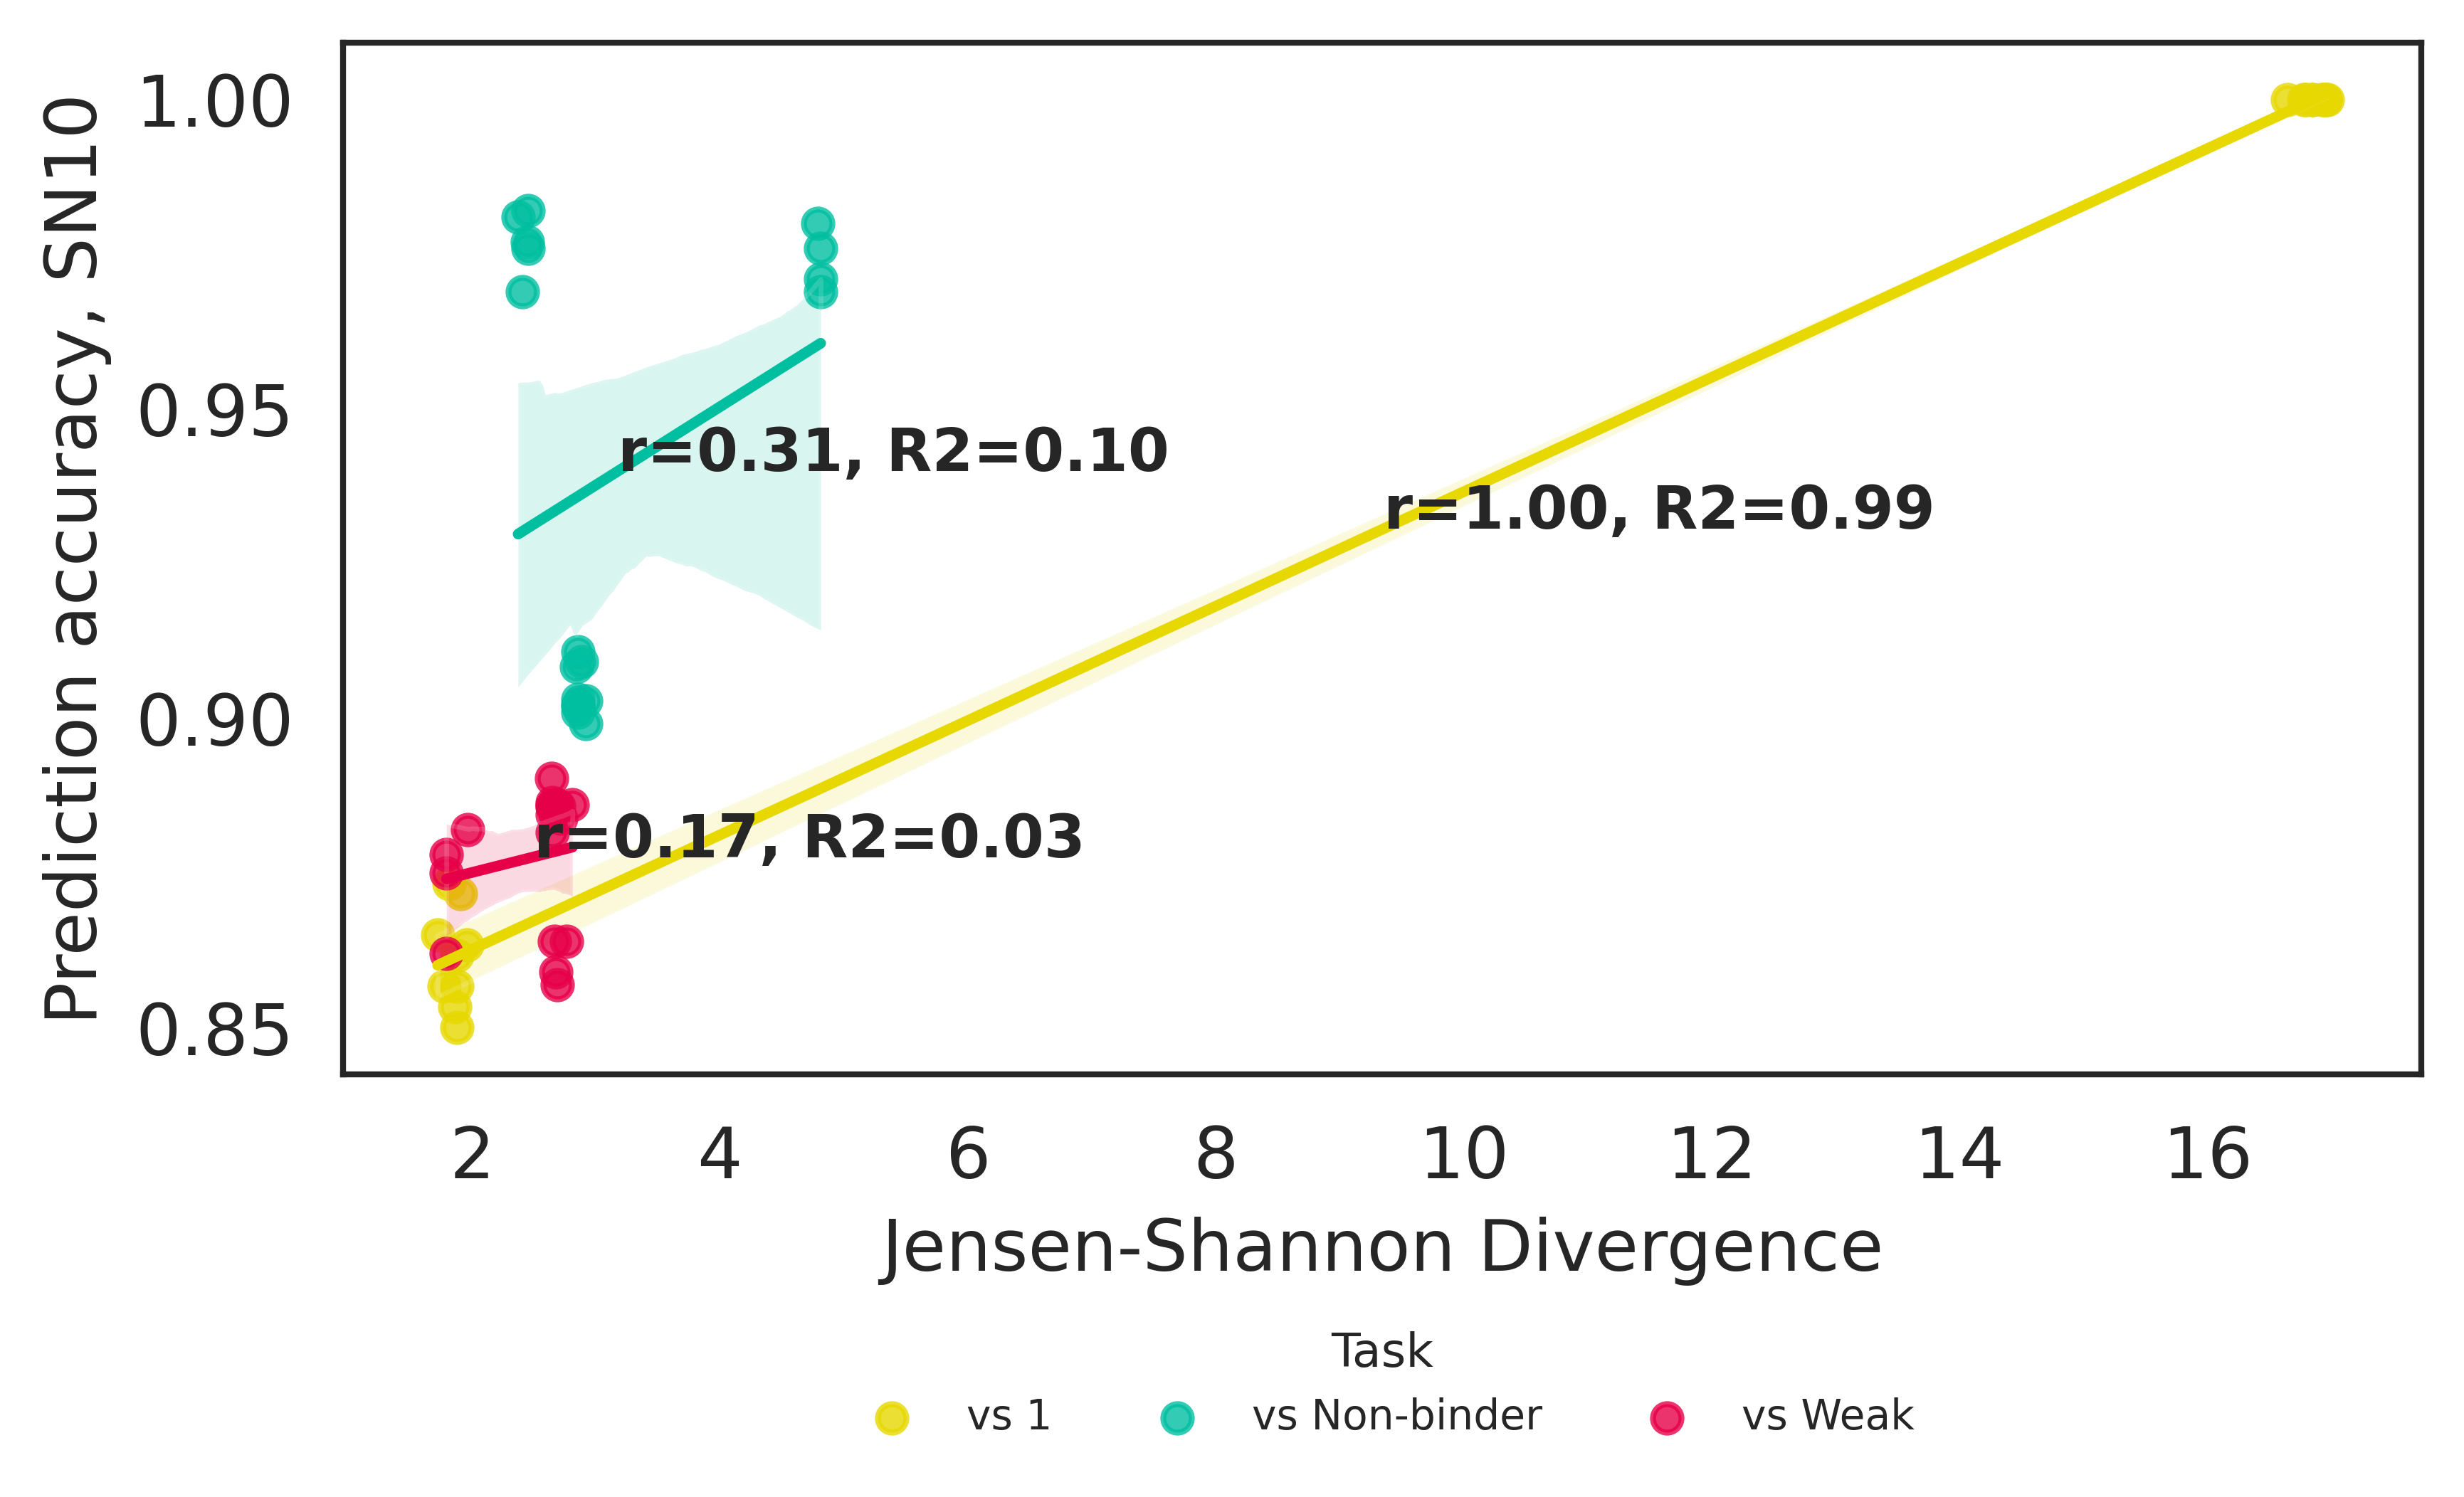

In [23]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for i, df_g in df.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="jsd",
        y="acc_closed",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

fig.savefig("figures/1B.svg")
fig.show()

## 1C. Openset performances.

Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [24]:
df_o = pd.read_csv("../data/openset_performance_experimental_data.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(1620, 10)


,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id
0,HIGH_VS_95LOW__HR2B__auto__0__42,HIGH_VS_95LOW__HR2B__auto__0__42,0.9080,0.92,0.898438,0.909091,HR2B,high_vs_95low,high_vs_95low,0_42
1,HIGH_VS_95LOW__HR2B__auto__0__42,HIGH_VS_LOOSER__HR2B__auto__0__42,0.7387,0.92,0.675180,0.778803,HR2B,high_vs_95low,high_vs_looser,0_42
2,HIGH_VS_95LOW__HR2B__auto__0__42,HIGH_VS_95LOW__HR2B__auto__1__42,0.9080,0.92,0.898438,0.909091,HR2B,high_vs_95low,high_vs_95low,0_42
3,HIGH_VS_95LOW__HR2B__auto__0__42,HIGH_VS_LOOSER__HR2B__auto__1__42,0.7387,0.92,0.675180,0.778803,HR2B,high_vs_95low,high_vs_looser,0_42
4,HIGH_VS_95LOW__HR2B__auto__0__42,HIGH_VS_95LOW__HR2B__auto__2__42,0.9080,0.92,0.898438,0.909091,HR2B,high_vs_95low,high_vs_95low,0_42


In [25]:
# To preserve functionality, keep the code working only
# on high_vs_looser and high_vs_95low. Save the other (vs 1)
# for separate analysis.
df_o_all = df_o.copy()
df_o = df_o.query("task_1_type != '1v1' and task_2_type != '1v1'").copy()

In [26]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

Clustermap

In [27]:
df_o_agg = df_o.groupby(["ag", "model_task", "test_task"])["acc"].mean().reset_index()
df_o_agg.head()

,ag,model_task,test_task,acc
0,HR2B,vs Non-binder,vs Non-binder,0.911275
1,HR2B,vs Non-binder,vs Weak,0.746684
2,HR2B,vs Weak,vs Non-binder,0.771202
3,HR2B,vs Weak,vs Weak,0.889499
4,HR2P,vs Non-binder,vs Non-binder,0.982012


Text(930.0833333333331, 0.5, 'Antigen')

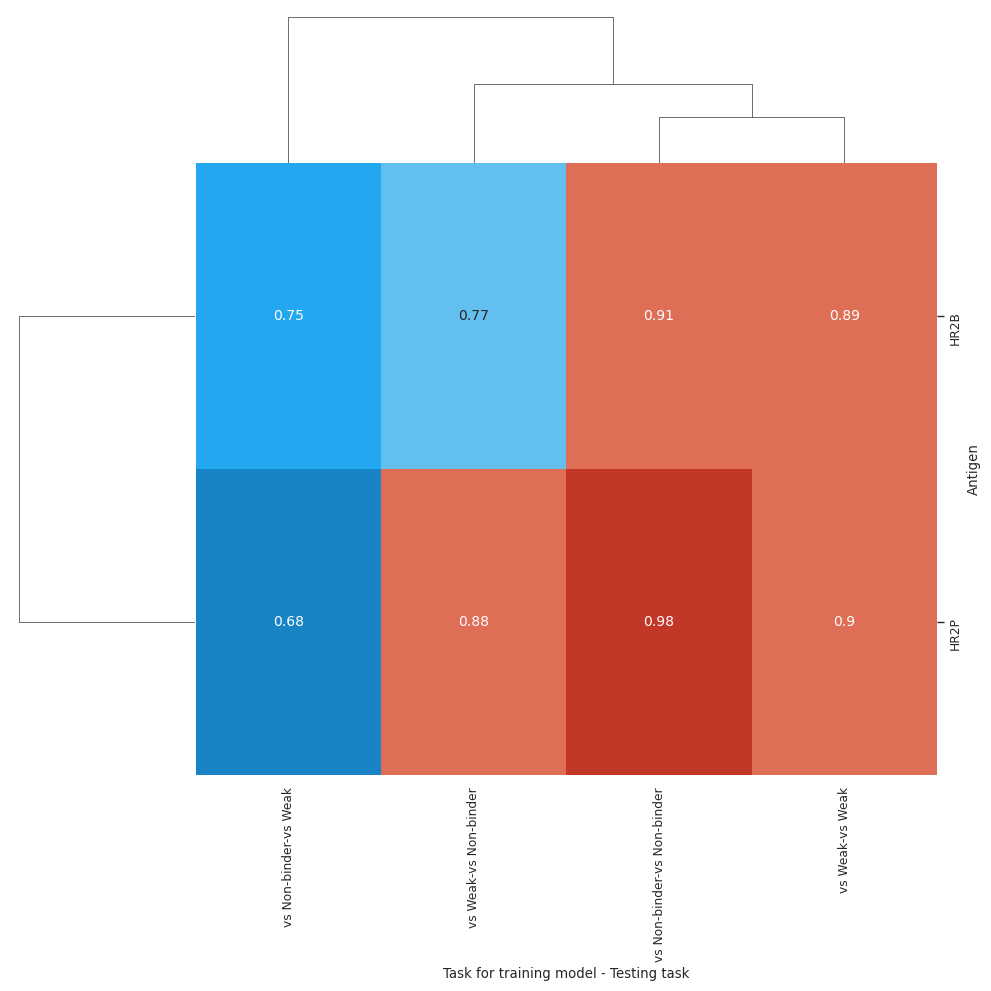

In [28]:
g = sns.clustermap(
    df_o_agg.pivot(index="ag", columns=["model_task", "test_task"], values="acc"),
    # .drop(axis=1, columns=[("1v9", "1v9"), ("high_vs_looser", "high_vs_looser"), ("high_vs_95low", "high_vs_95low")]),
    cmap=[
        "#1984c5",
        "#22a7f0",
        "#63bff0",
        "#a7d5ed",
        "#e2e2e2",
        "#e1a692",
        "#de6e56",
        "#e14b31",
        "#c23728",
    ],
    annot=True,
    annot_kws={"size": 10},
    metric="euclidean",
)
g.cax.set_visible(False)
g.ax_heatmap.set_xlabel("Task for training model - Testing task")
g.ax_heatmap.set_ylabel("Antigen")

Plots from Aygul

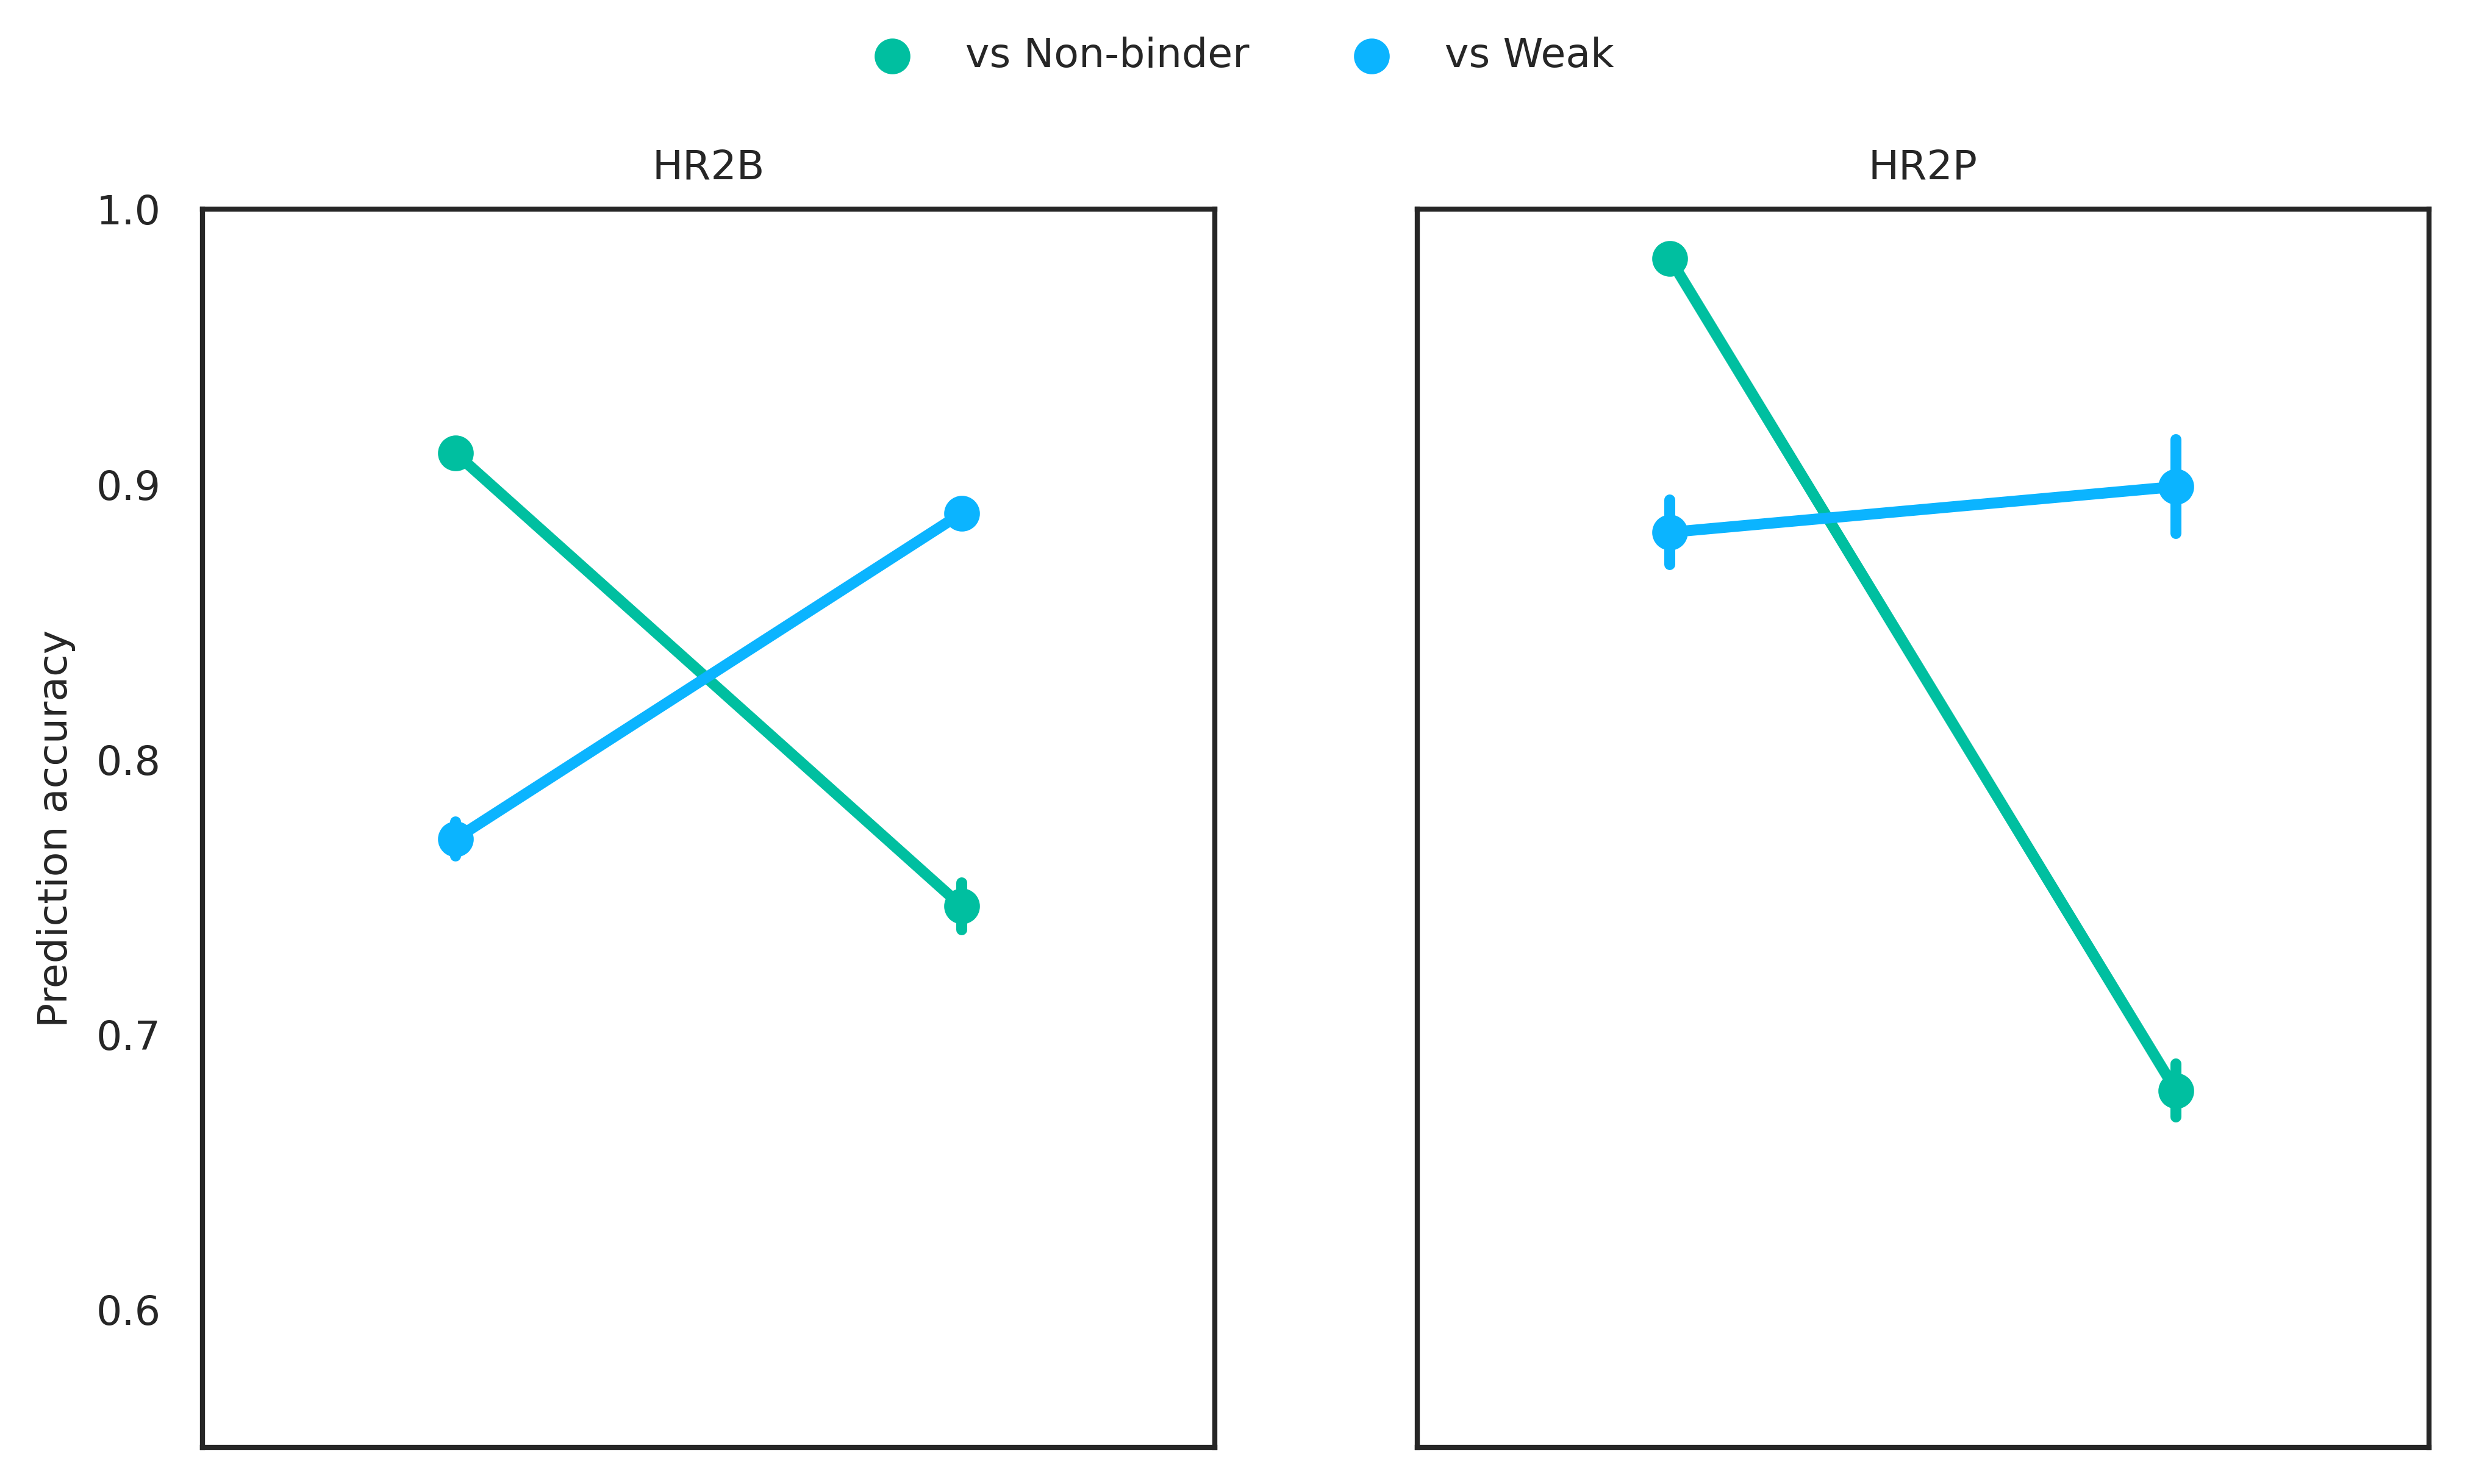

In [29]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

order_tasks_nonclean = ["high_vs_95low", "high_vs_looser"]
task_order = list(map(lambda x: map_task_type_to_clean[x], order_tasks_nonclean))

order_antigens = ["HR2B", "HR2P"]

for i, ag in enumerate(order_antigens):
    row = 0
    col = i
    ax = axs[col]
    df_i = df_o.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.55, 1.0)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

    # Tables inside the plot
    if row == 1 and col in [1, 2]:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (
        df_i.groupby(["model_task", "test_task"])["acc"]
        .mean()
        .reset_index()
        .pivot(index="model_task", columns="test_task", values="acc")
        .loc[task_order][task_order]
        .values * 100).round().astype(int)
    table_values = np.where(table_values == 100, "", table_values)
    # ax.table(
    #     cellText=table_values,
    #     loc=loc,
    #     colWidths=[0.1, 0.1, 0.1],
    #     cellColours=np.array([cmap for _ in range(3)]).transpose(),
    # )

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

# Add text horizontal under all subplots, as part of figure
# fig.text(0.5, 0.001, "Tested on", ha="center", fontsize=8);

# fig.savefig("figures/1D1.svg")
fig.show()

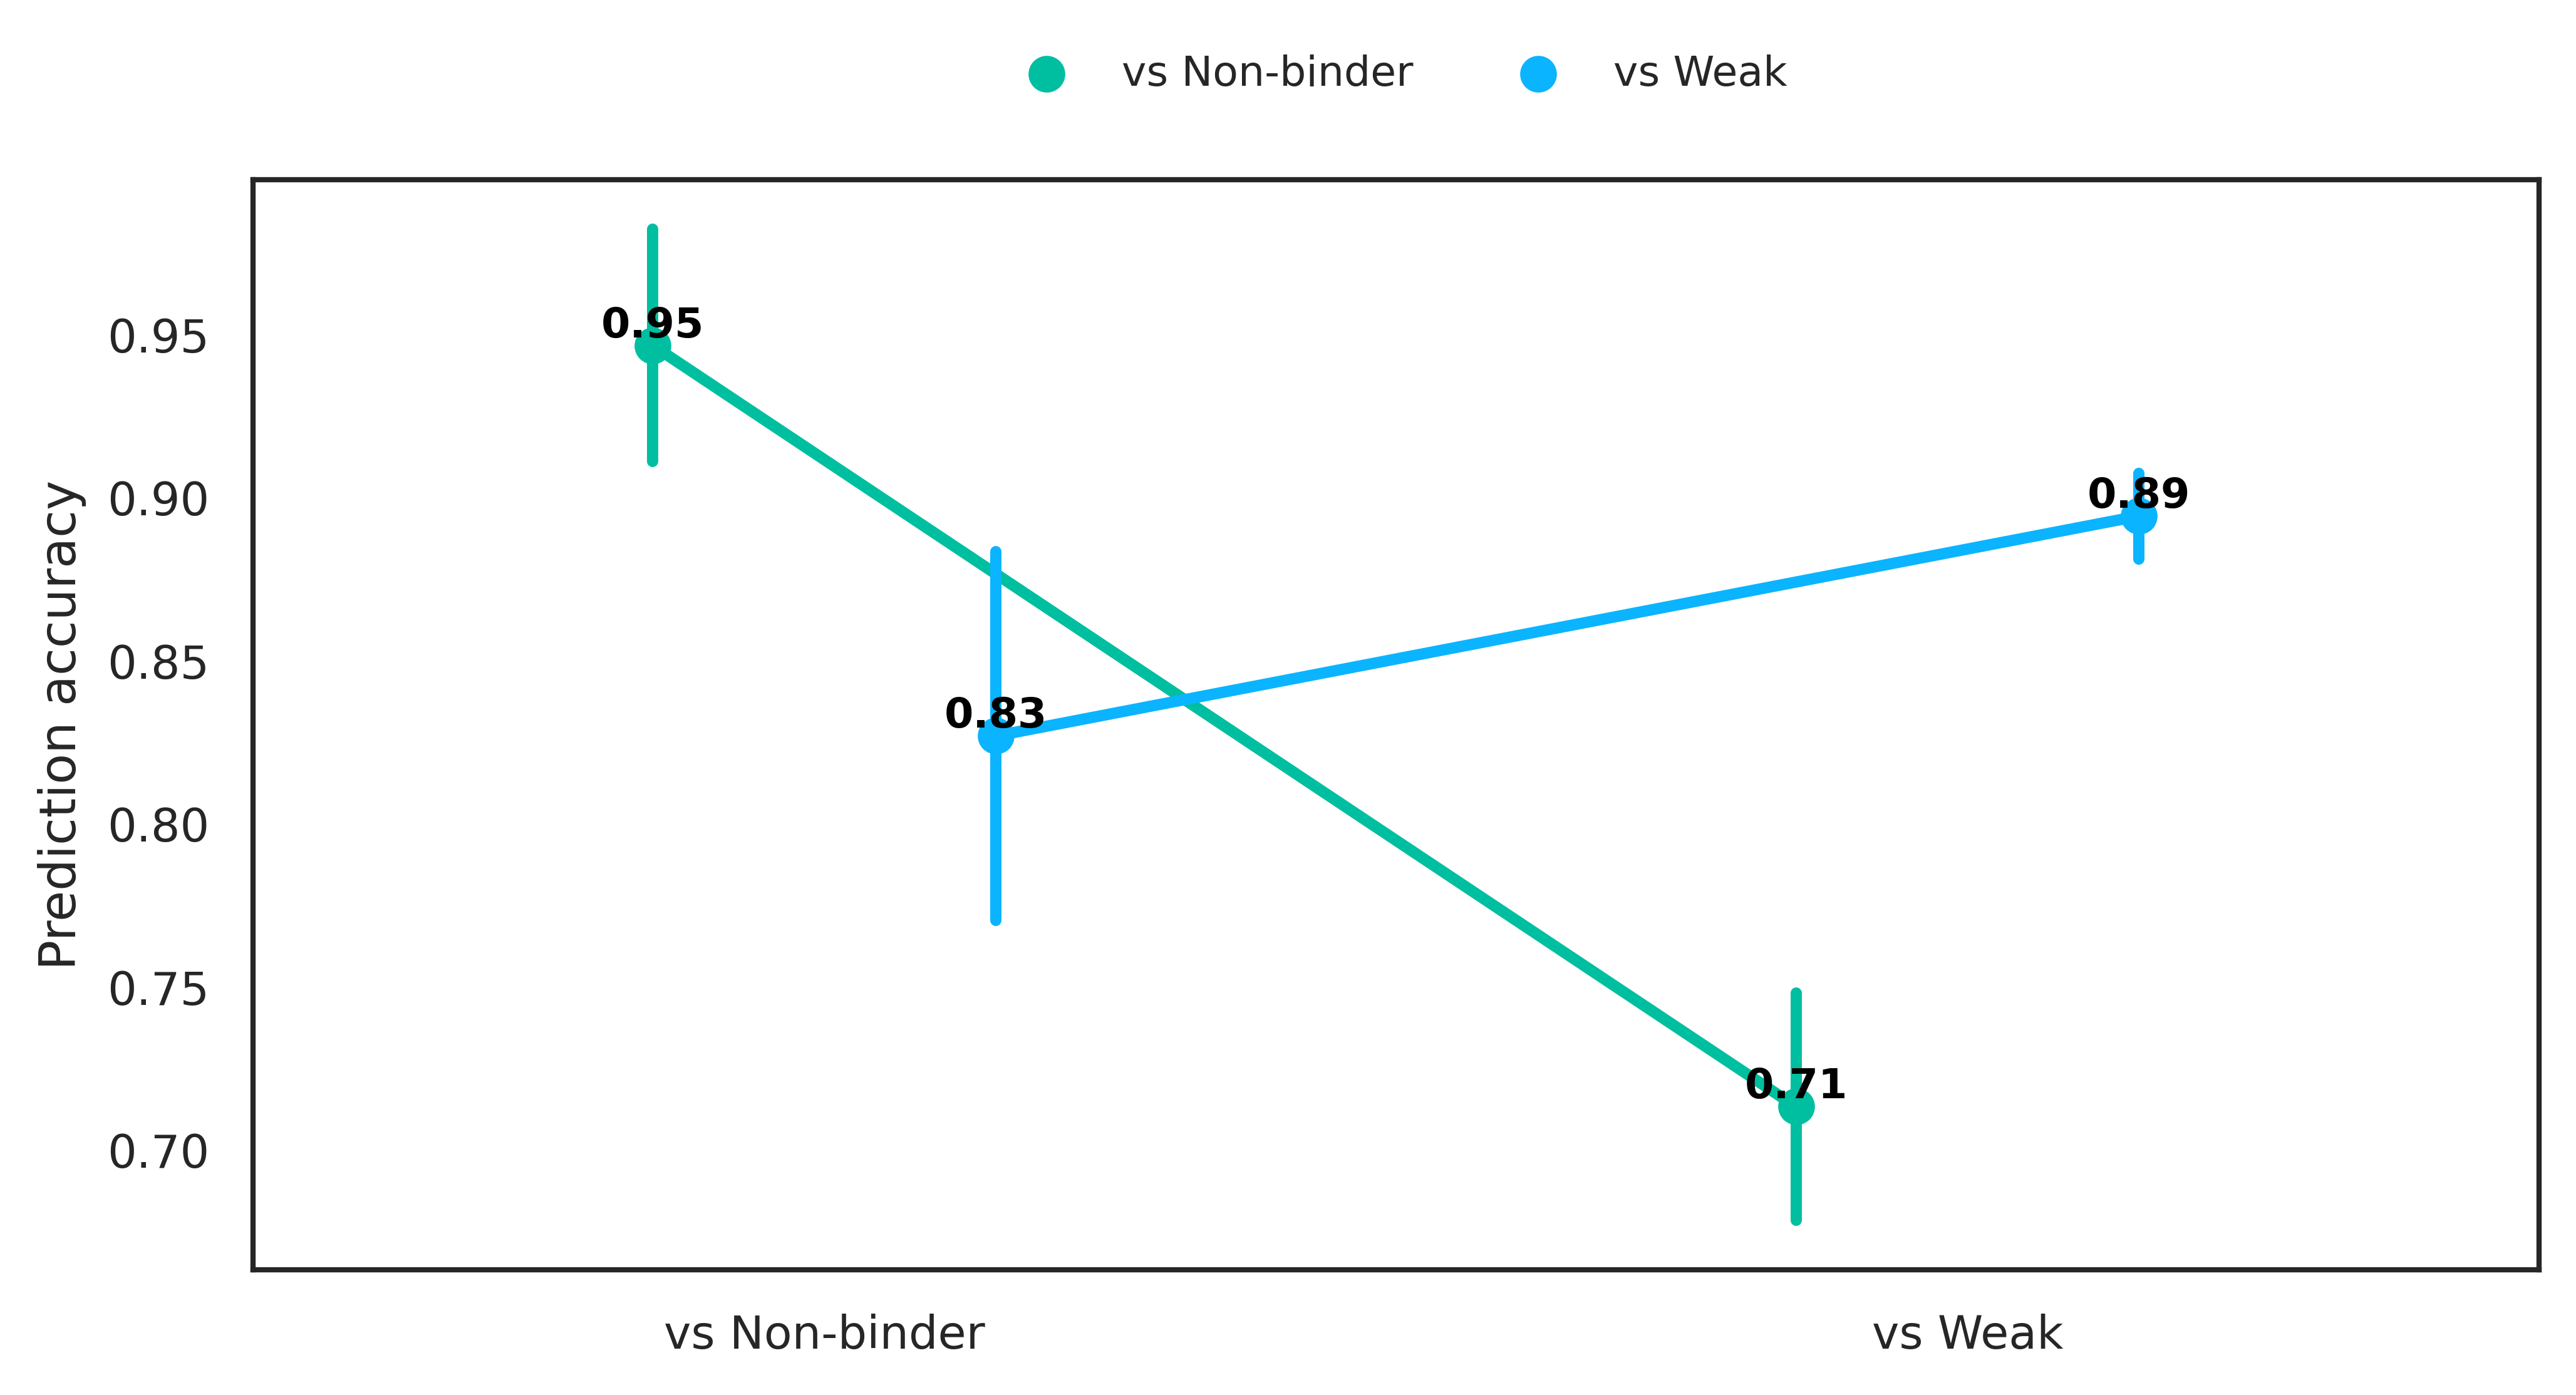

In [30]:
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.savefig("figures/1D2.svg")
fig.show()

Check for results for the randomized sequences in HR2P

In [31]:
# Drop HR2B
df_o_all = df_o_all.query("ag != 'HR2B'").copy()

for _, row in df_o_all.iterrows():
    
    if row["task_1"].split("__")[-3] == "HR2PSR":
        task_1_type = "high_vs_randseq"
    elif row["task_1"].split("__")[-3] == "HR2PIR":
        task_1_type = "high_vs_randpos"
    else:
        task_1_type = row["task_1_type"]
    df_o_all.loc[_, "task_1_type"] = task_1_type

    # Same for task_2
    if row["task_2"].split("__")[-3] == "HR2PSR":
        task_2_type = "high_vs_randseq"
    elif row["task_2"].split("__")[-3] == "HR2PIR":
        task_2_type = "high_vs_randpos"
    else:
        task_2_type = row["task_2_type"]
    df_o_all.loc[_, "task_2_type"] = task_2_type

df_o_all["model_task"] = df_o_all["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o_all["test_task"] = df_o_all["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

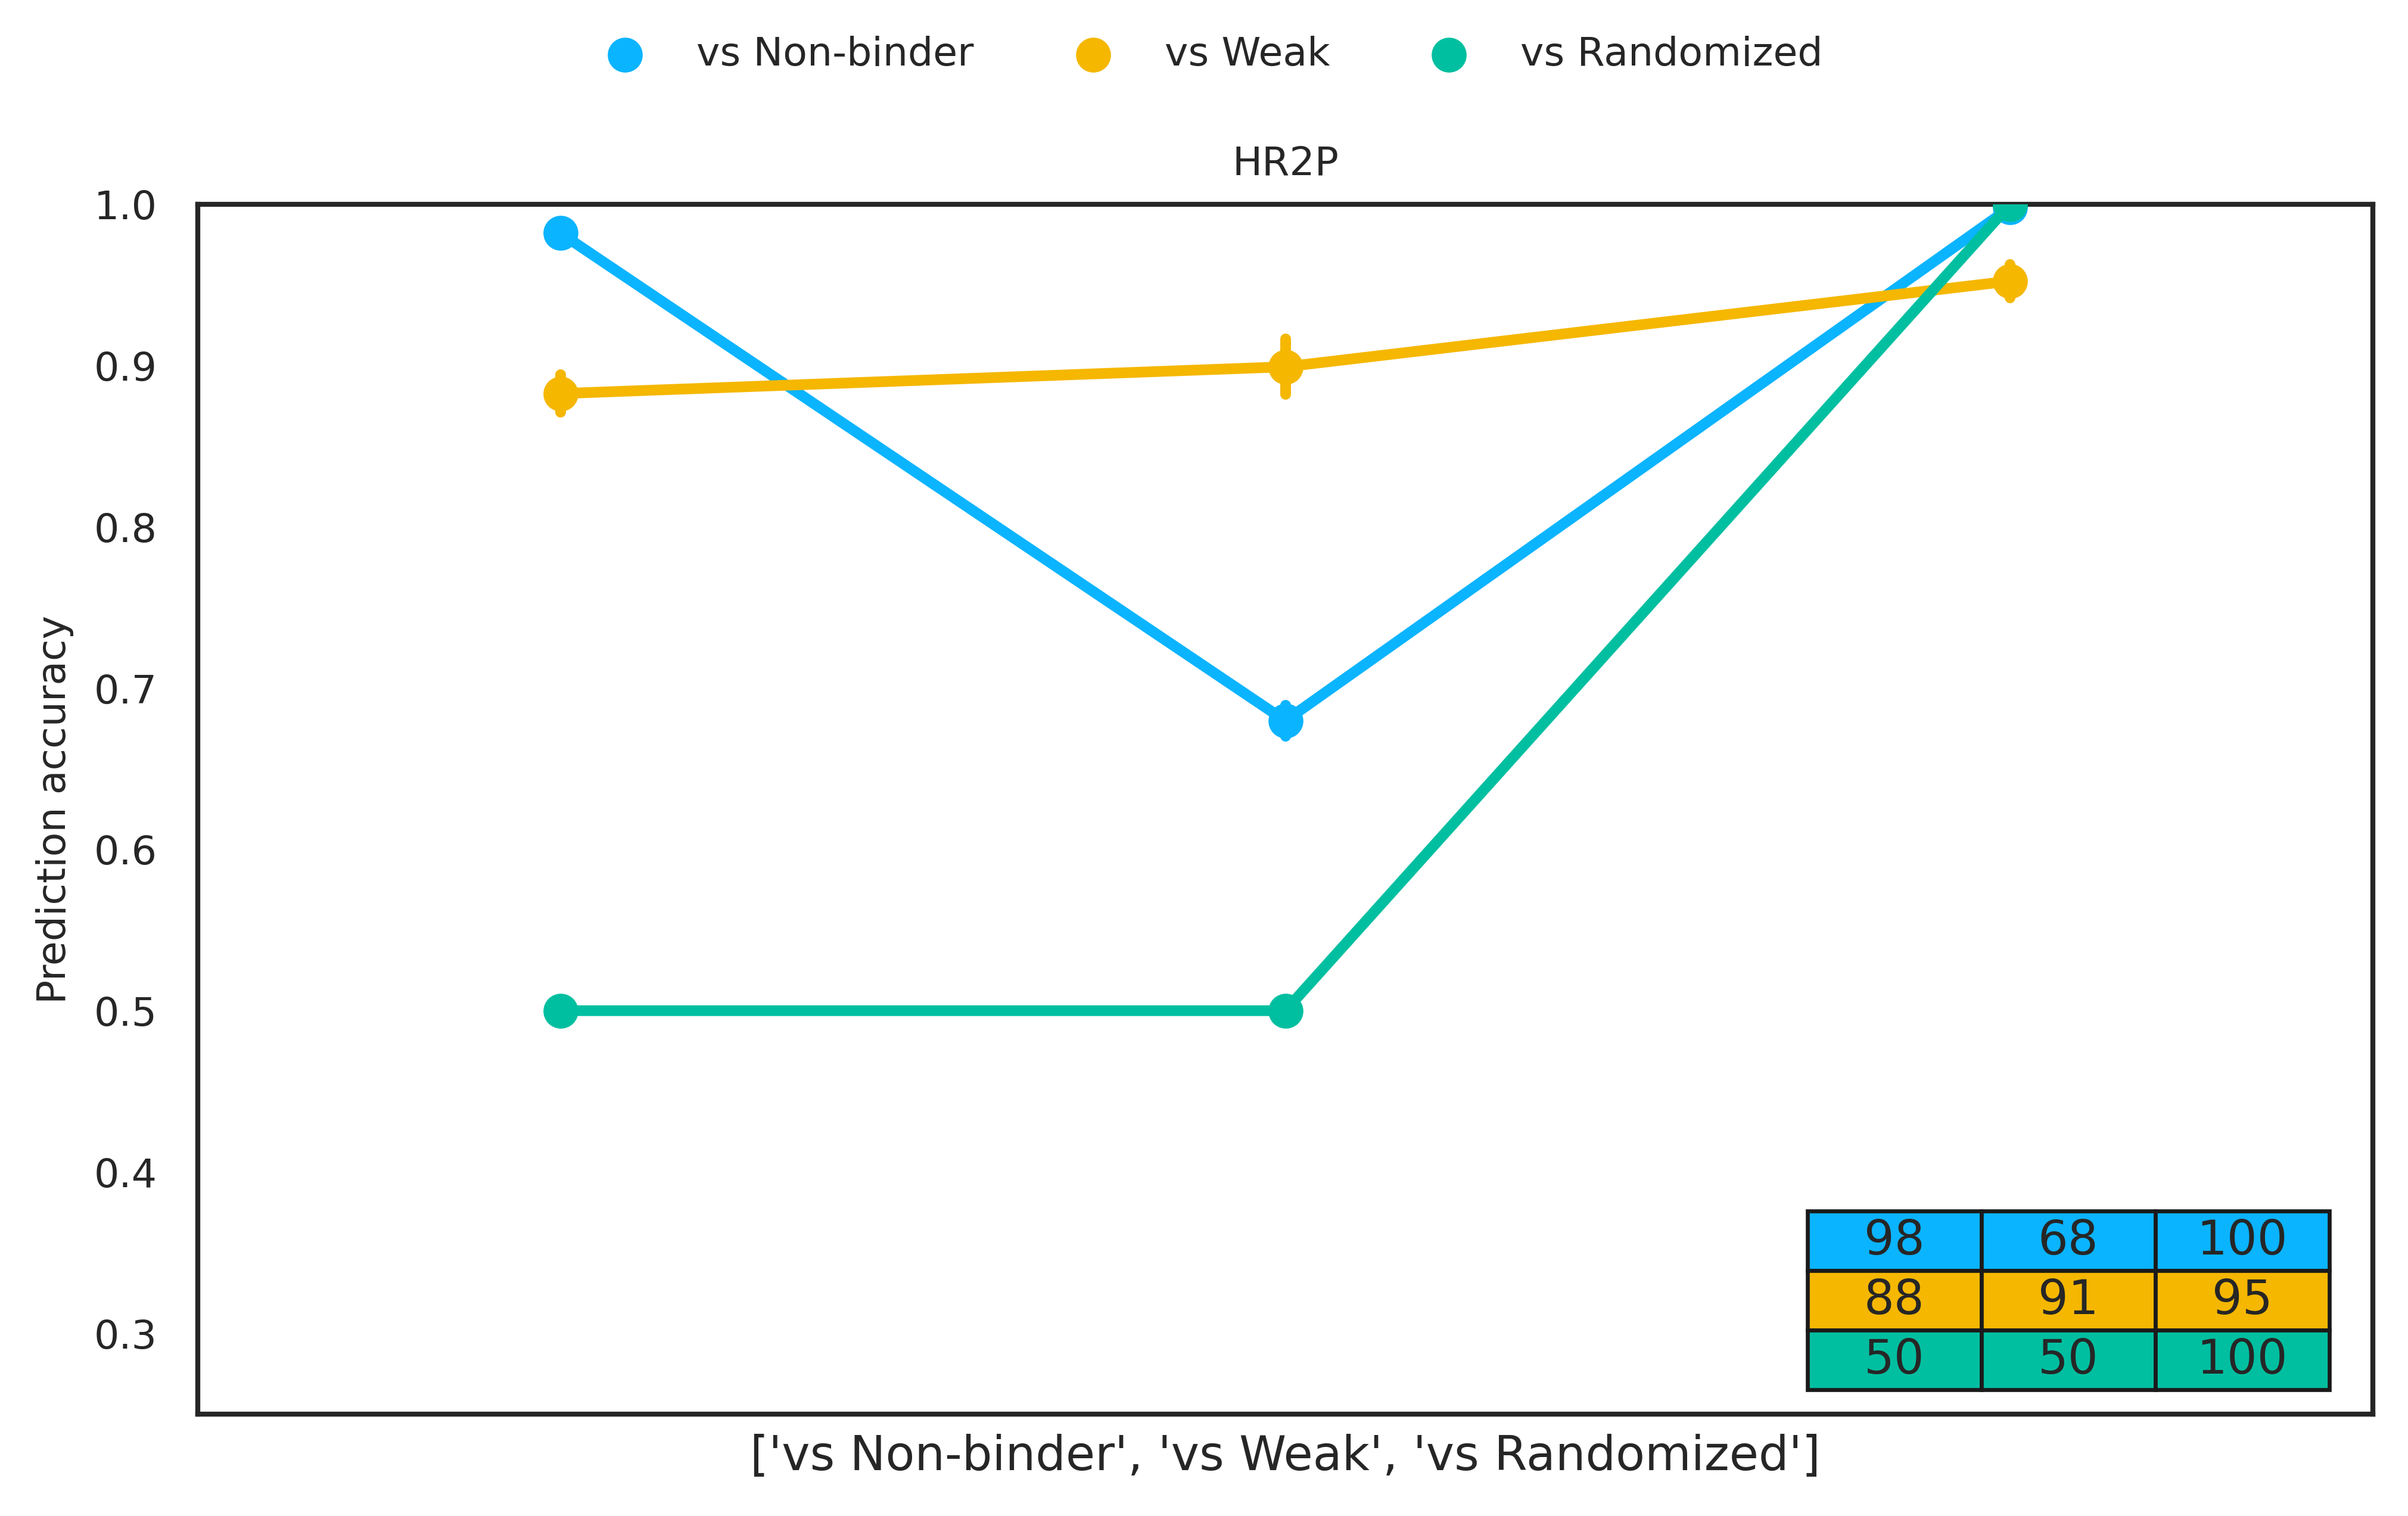

In [32]:
cmap = [
    # Selection from Dutch Field
    "#0bb4ff",  # Blue
    "#f5b700",  # Yellow
    "#00bfa0",  # Dark Green
    # "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

# order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "high_vs_randseq", "high_vs_randpos"]
order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "high_vs_randseq"]
task_order = list(map(lambda x: map_task_type_to_clean[x], order_tasks_nonclean))

order_antigens = ["HR2P"]

for i, ag in enumerate(order_antigens):
    row = 0
    col = i
    ax = axs
    df_i = df_o_all.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.25, 1.0)
    ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_xlabel(task_order)
    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

# Add table
loc = "lower right"
table_values = (
    df_i.groupby(["model_task", "test_task"])["acc"]
    .median()
    .reset_index()
    .pivot(index="model_task", columns="test_task", values="acc")
    .loc[task_order][task_order]
    .values * 100).round().astype(int)
# table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc=loc,
    cellLoc="center",
    colWidths=[0.08, 0.08, 0.08],
    cellColours=np.array([cmap for _ in range(3)]).transpose(),
)

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

# Add text horizontal under all subplots, as part of figure
# fig.text(0.5, 0.001, "Tested on", ha="center", fontsize=8);

# fig.savefig("figures/1D1.svg")
fig.show()